In [1]:
import glob
import os

import numpy as np
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

results = {}
for method in ['deseq', 'edgeR']:
    tables = {}
    for file in glob.glob(f'diffbind/*{method}*'):
        key = os.path.basename(file).split('.')[0]
        df = pd.read_csv(
            file,
            index_col=0
        )
        df.rename(
            columns = {
                'PValue': 'pvalue',
                'logFC': 'log2FoldChange'
            },
            inplace = True
        )
        reject, padj = fdrcorrection(df.pvalue)
        df['padj'] = padj
        df['-log10(padj)'] = -np.log10(padj)
        tables[key] = df
    
    results[method] = tables

In [3]:
peaks = [
    'h3k4me1_all', 
    'h3k4me1_reproducible', 
    'h3k27ac_all', 
    'h3k27ac_reproducible'
]

closest_genes = {}
for key in peaks:
    df = pd.read_csv(
        f'closest/{key.replace("_", ".")}.closestgenes.bed',
        header = None,
        usecols = [0, 1, 2, 6, 7, 8, 9],
        sep = '\t',
        names = ['chr', 'start', 'end', 'gene_name', 'score', 'strand', 'distance']
    )
    df.index = df[['chr', 'start', 'end']].apply(
        lambda x: ':'.join(str(i) for i in x),
        axis = 1
    )
    closest_genes[key] = df.drop(
        columns = ['chr', 'start', 'end']
    )

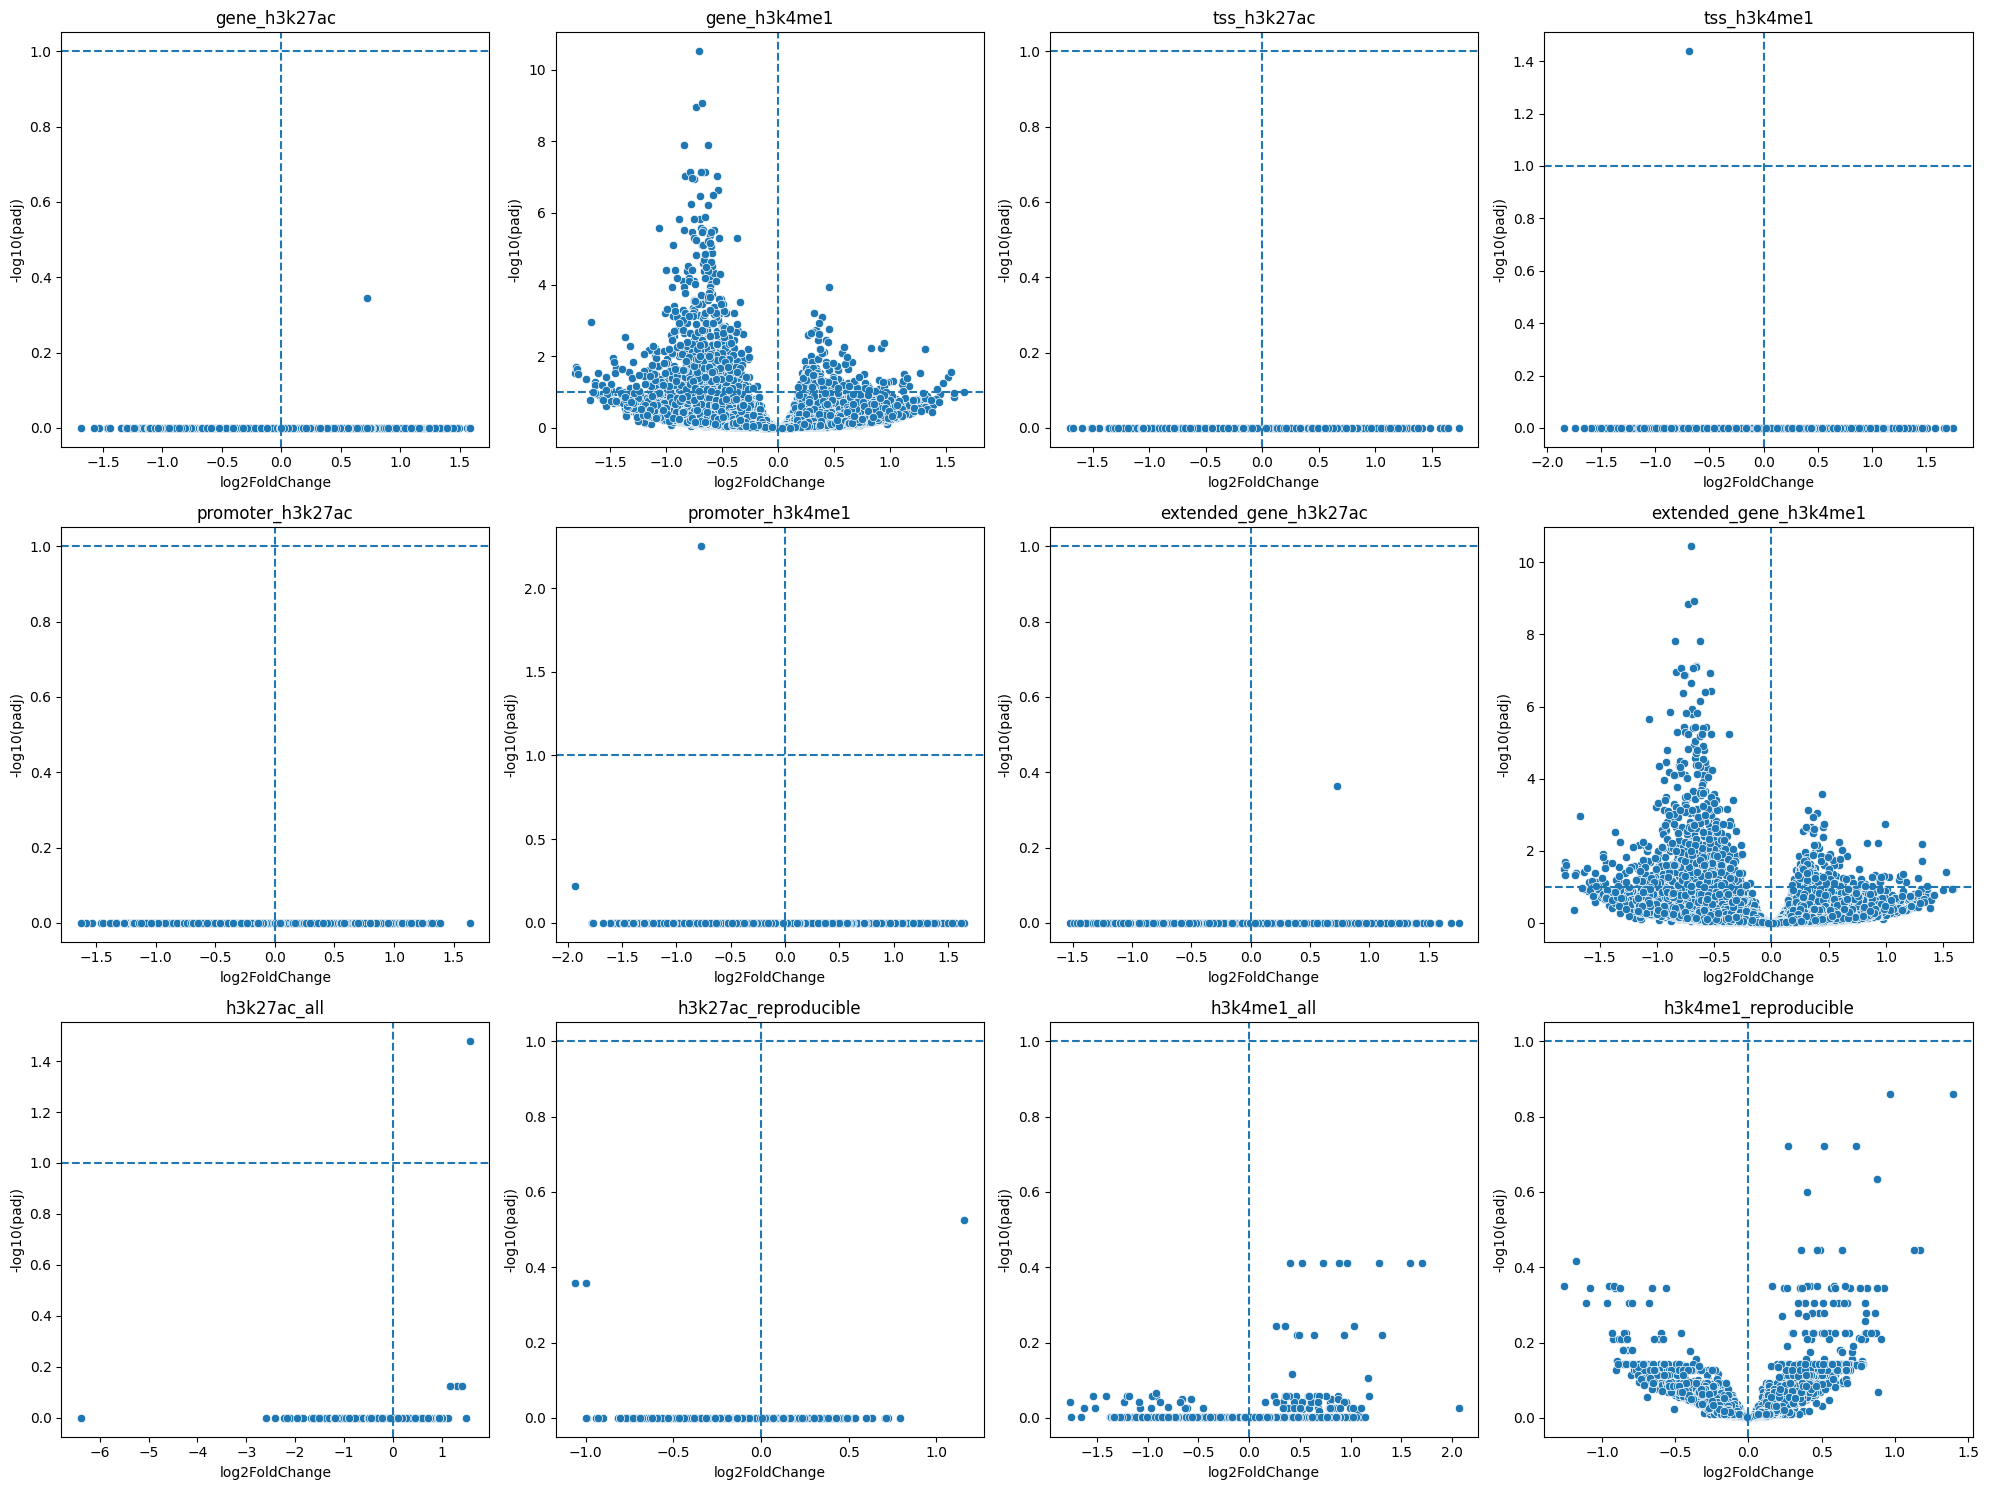

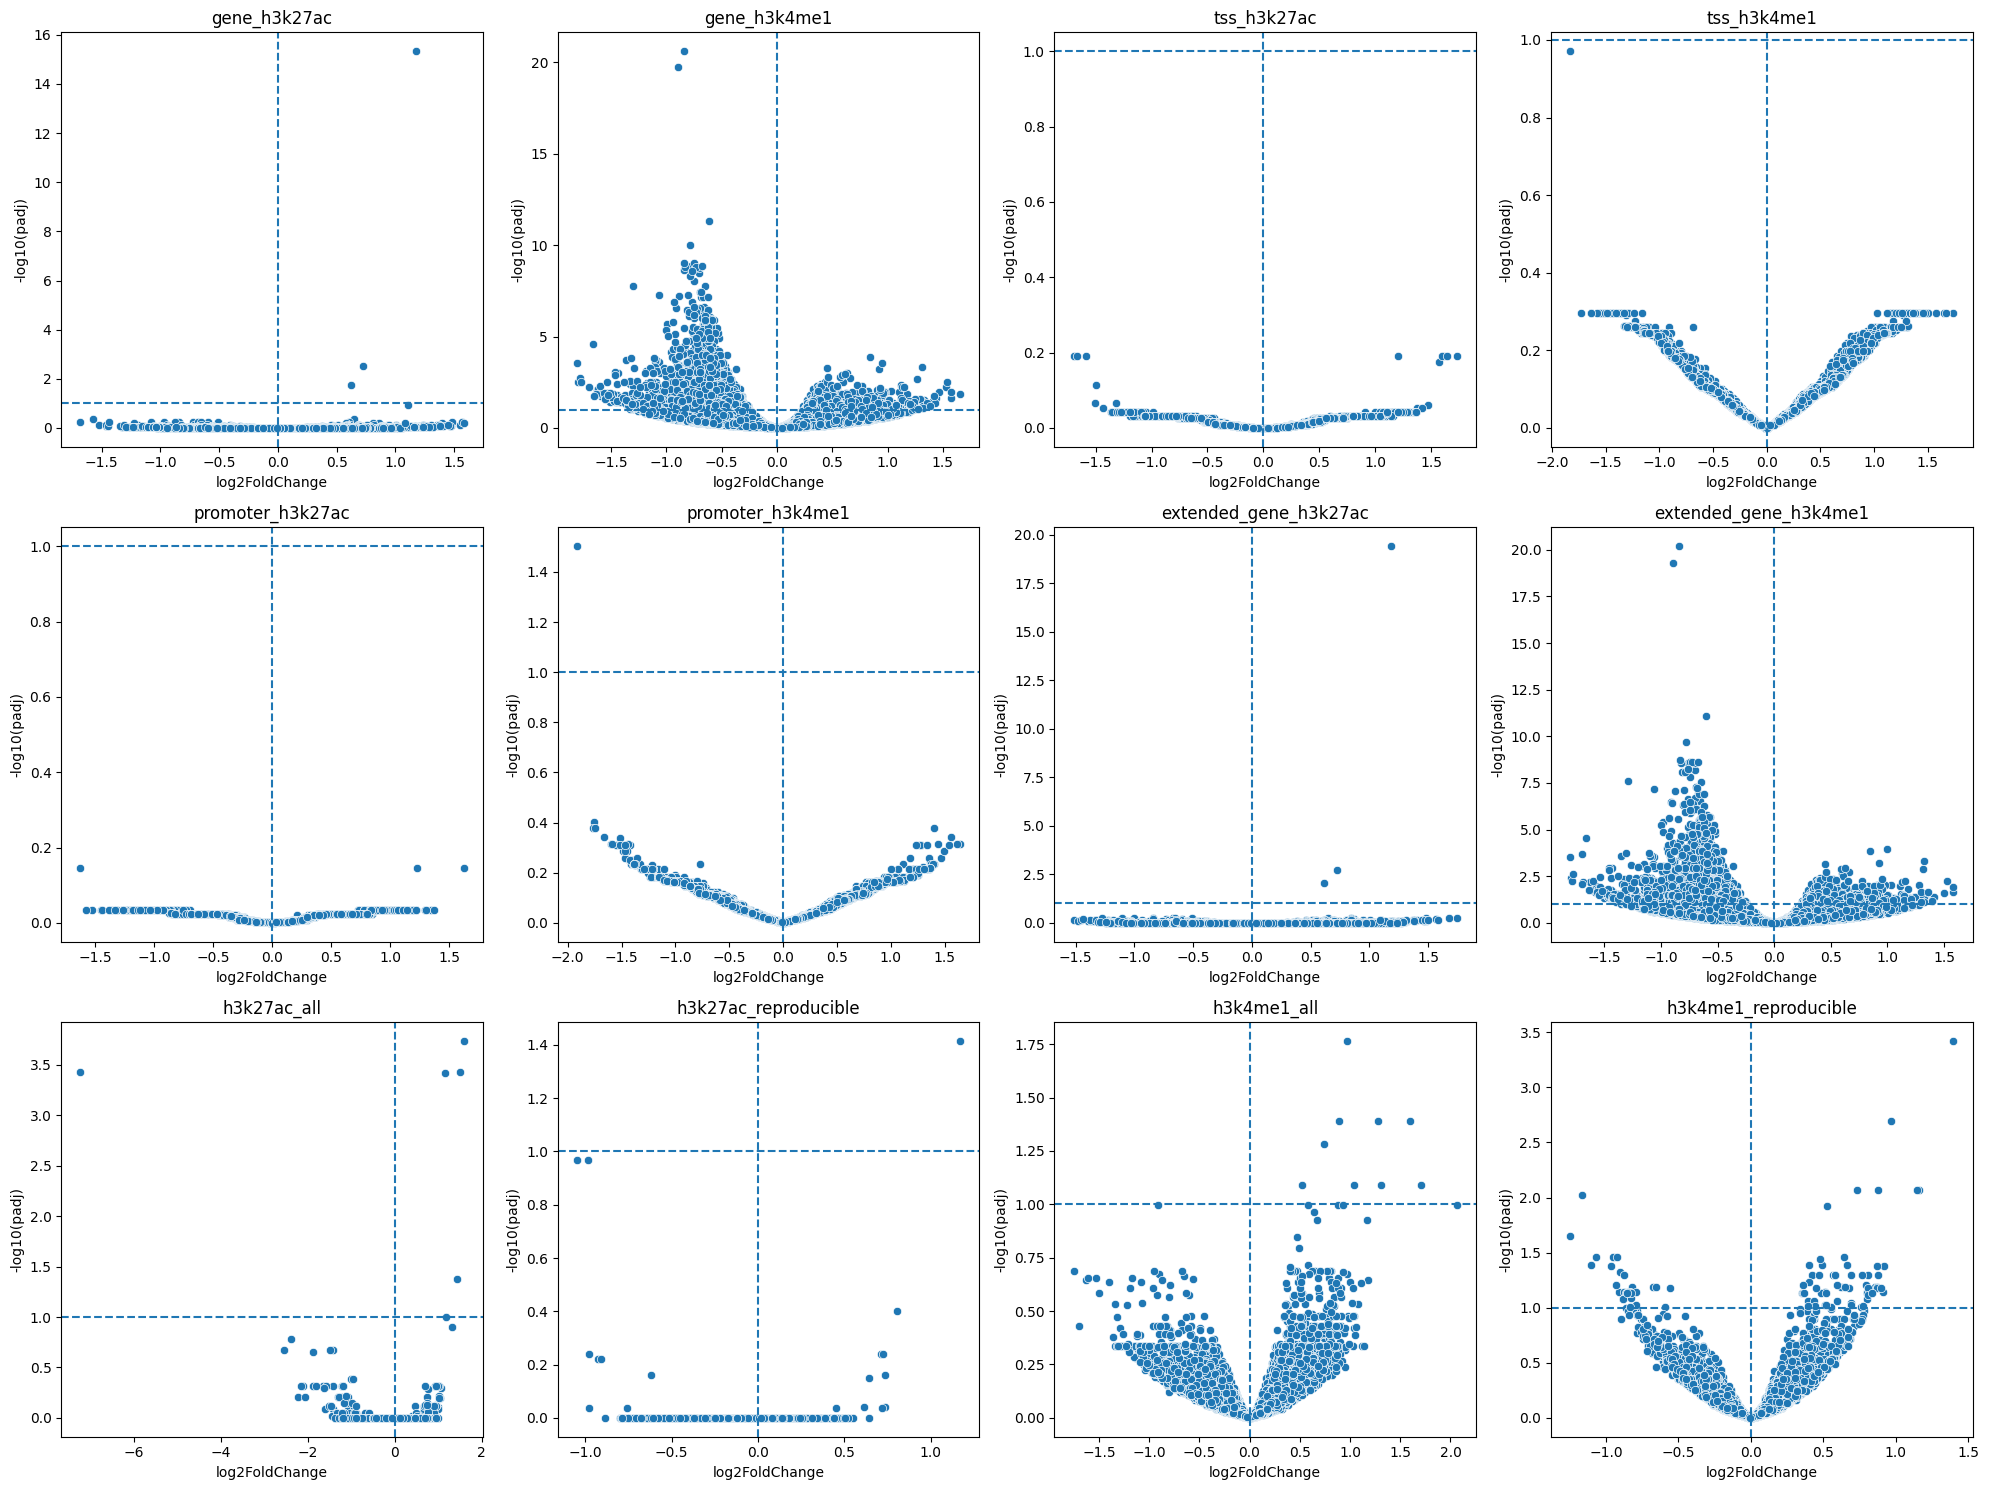

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

for method, tables in results.items():
    fig, axs = plt.subplots(3, 4)
    for ax, (key, df) in zip(axs.reshape(12), tables.items()):
        sns.scatterplot(
            data = df,
            x = 'log2FoldChange',
            y = '-log10(padj)',
            ax = ax
        )
        ax.set_title(key)
        ax.axvline(0, ls = '--')
        ax.axhline(-np.log10(0.1), ls ='--')
    
    fig.set_figwidth(20)
    fig.set_figheight(15)
    fig.tight_layout()

In [16]:
key = 'h3k4me1_reproducible'
df = results['edgeR'][key]
df = df.merge(
    closest_genes[key],
    left_index = True,
    right_index = True,
    how = 'inner'
)
data = []
for i, row in df[df.padj < 0.1].iterrows():
    data.append(
        [
            row.gene_name, 
            row.log2FoldChange, 
            row.padj, 
            'up' if row.log2FoldChange > 0 else 'down', 
            row.distance
        ]
    )
    
peaks = pd.DataFrame(
    data,
    columns = [
        'close_gene', 
        'log2FC', 
        'padj', 
        'regulation', 
        'distance_to_peak'
    ]
)
peaks.to_csv(
    'close_genes_to_significant_h3k4me1_peaks_fdr0.1.csv',
    index = False
)

In [33]:
import gseapy as gp

peaks_upregulated = peaks[peaks.log2FC > 0].close_gene.apply(
    lambda x: x.split(';')[1]
).to_list()
peaks_downregulated = peaks[peaks.log2FC < 0].close_gene.apply(
    lambda x: x.split(';')[1]
).to_list()

In [40]:
res = gp.enrichr(
    peaks_upregulated,
    gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']
)
results = res.results
results[results['Adjusted P-value'] < 0.2].head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
28,GO_Biological_Process_2023,Interleukin-2-Mediated Signaling Pathway (GO:0...,2/7,0.000564,0.140965,0,0,77.242718,577.873085,IL2RB;STAT3
29,GO_Biological_Process_2023,Cellular Response To Interleukin-2 (GO:0071352),2/7,0.000564,0.140965,0,0,77.242718,577.873085,IL2RB;STAT3
30,GO_Biological_Process_2023,Cellular Response To Vascular Endothelial Grow...,3/34,0.000747,0.140965,0,0,18.846300,135.671568,DLL4;EGR3;MAPKAPK2
31,GO_Biological_Process_2023,DNA Cytosine Deamination (GO:0070383),2/8,0.000749,0.140965,0,0,64.365696,463.240666,APOBEC3G;APOBEC3H
32,GO_Biological_Process_2023,Interleukin-15-Mediated Signaling Pathway (GO:...,2/10,0.001195,0.150002,0,0,48.269417,324.824808,IL2RB;STAT3
33,GO_Biological_Process_2023,Cellular Response To Interleukin-15 (GO:0071350),2/10,0.001195,0.150002,0,0,48.269417,324.824808,IL2RB;STAT3
34,GO_Biological_Process_2023,Cytidine To Uridine Editing (GO:0016554),2/11,0.001456,0.156607,0,0,42.903991,280.256124,APOBEC3G;APOBEC3H
35,GO_Biological_Process_2023,DNA Deamination (GO:0045006),2/12,0.001741,0.163875,0,0,38.611650,245.310386,APOBEC3G;APOBEC3H
36,GO_Biological_Process_2023,Negative Regulation Of Single Stranded Viral R...,2/14,0.002384,0.179526,0,0,32.173139,194.290943,APOBEC3G;APOBEC3H
37,GO_Biological_Process_2023,Regulation Of Transposition (GO:0010528),2/14,0.002384,0.179526,0,0,32.173139,194.290943,APOBEC3G;APOBEC3H


In [39]:
res = gp.enrichr(
    peaks_downregulated,
    gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']
)
results = res.results
results[results['Adjusted P-value'] < 0.2].head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Estrogen Response Late,3/200,0.009062,0.081557,0,0,7.522843,35.385032,MAPT;AFF1;JAK1
1,MSigDB_Hallmark_2020,Mitotic Spindle,2/199,0.068192,0.154777,0,0,4.892906,13.139520,DOCK2;NDC80
2,MSigDB_Hallmark_2020,mTORC1 Signaling,2/200,0.068790,0.154777,0,0,4.867948,13.030046,PSMC6;ELOVL6
3,MSigDB_Hallmark_2020,Estrogen Response Early,2/200,0.068790,0.154777,0,0,4.867948,13.030046,MAPT;AFF1
9,GO_Biological_Process_2023,Regulation Of Axon Extension (GO:0030516),2/35,0.002568,0.119485,0,0,29.451589,175.665475,RNF6;MAPT
10,GO_Biological_Process_2023,Ubiquitin-Dependent Protein Catabolic Process ...,4/367,0.007833,0.119485,0,0,5.536201,26.847050,RNF144A;PSMC6;FEM1C;RNF6
11,GO_Biological_Process_2023,Modification-Dependent Protein Catabolic Proce...,3/192,0.008108,0.119485,0,0,7.844444,37.770333,RNF144A;FEM1C;RNF6
12,GO_Biological_Process_2023,Regulation Of pro-B Cell Differentiation (GO:2...,1/5,0.010705,0.119485,0,0,118.767857,538.856886,FNIP1
13,GO_Biological_Process_2023,Plus-End-Directed Organelle Transport Along Mi...,1/5,0.010705,0.119485,0,0,118.767857,538.856886,MAPT
14,GO_Biological_Process_2023,RNA Decapping (GO:0110154),1/5,0.010705,0.119485,0,0,118.767857,538.856886,DCPS


In [17]:
genes = results['edgeR']['extended_gene_h3k4me1']
genes[genes.padj < 0.01].to_csv(
    'significant_genes_extended_fdr0.01.csv',
    index = False
)

In [41]:
genes_upregulated = peaks[peaks.log2FC > 0].close_gene.apply(
    lambda x: x.split(';')[1]
).to_list()
genes_downregulated = peaks[peaks.log2FC < 0].close_gene.apply(
    lambda x: x.split(';')[1]
).to_list()

In [44]:
res = gp.enrichr(
    genes_upregulated,
    gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']
)
results = res.results
results[results['Adjusted P-value'] < 0.2].head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
28,GO_Biological_Process_2023,Interleukin-2-Mediated Signaling Pathway (GO:0...,2/7,0.000564,0.140965,0,0,77.242718,577.873085,IL2RB;STAT3
29,GO_Biological_Process_2023,Cellular Response To Interleukin-2 (GO:0071352),2/7,0.000564,0.140965,0,0,77.242718,577.873085,IL2RB;STAT3
30,GO_Biological_Process_2023,Cellular Response To Vascular Endothelial Grow...,3/34,0.000747,0.140965,0,0,18.846300,135.671568,DLL4;EGR3;MAPKAPK2
31,GO_Biological_Process_2023,DNA Cytosine Deamination (GO:0070383),2/8,0.000749,0.140965,0,0,64.365696,463.240666,APOBEC3G;APOBEC3H
32,GO_Biological_Process_2023,Interleukin-15-Mediated Signaling Pathway (GO:...,2/10,0.001195,0.150002,0,0,48.269417,324.824808,IL2RB;STAT3
33,GO_Biological_Process_2023,Cellular Response To Interleukin-15 (GO:0071350),2/10,0.001195,0.150002,0,0,48.269417,324.824808,IL2RB;STAT3
34,GO_Biological_Process_2023,Cytidine To Uridine Editing (GO:0016554),2/11,0.001456,0.156607,0,0,42.903991,280.256124,APOBEC3G;APOBEC3H
35,GO_Biological_Process_2023,DNA Deamination (GO:0045006),2/12,0.001741,0.163875,0,0,38.611650,245.310386,APOBEC3G;APOBEC3H
36,GO_Biological_Process_2023,Negative Regulation Of Single Stranded Viral R...,2/14,0.002384,0.179526,0,0,32.173139,194.290943,APOBEC3G;APOBEC3H
37,GO_Biological_Process_2023,Regulation Of Transposition (GO:0010528),2/14,0.002384,0.179526,0,0,32.173139,194.290943,APOBEC3G;APOBEC3H


In [45]:
res = gp.enrichr(
    genes_downregulated,
    gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']
)
results = res.results
results[results['Adjusted P-value'] < 0.2].head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Estrogen Response Late,3/200,0.009062,0.081557,0,0,7.522843,35.385032,MAPT;AFF1;JAK1
1,MSigDB_Hallmark_2020,Mitotic Spindle,2/199,0.068192,0.154777,0,0,4.892906,13.139520,DOCK2;NDC80
2,MSigDB_Hallmark_2020,mTORC1 Signaling,2/200,0.068790,0.154777,0,0,4.867948,13.030046,PSMC6;ELOVL6
3,MSigDB_Hallmark_2020,Estrogen Response Early,2/200,0.068790,0.154777,0,0,4.867948,13.030046,MAPT;AFF1
9,GO_Biological_Process_2023,Regulation Of Axon Extension (GO:0030516),2/35,0.002568,0.119485,0,0,29.451589,175.665475,RNF6;MAPT
10,GO_Biological_Process_2023,Ubiquitin-Dependent Protein Catabolic Process ...,4/367,0.007833,0.119485,0,0,5.536201,26.847050,RNF144A;PSMC6;FEM1C;RNF6
11,GO_Biological_Process_2023,Modification-Dependent Protein Catabolic Proce...,3/192,0.008108,0.119485,0,0,7.844444,37.770333,RNF144A;FEM1C;RNF6
12,GO_Biological_Process_2023,Regulation Of pro-B Cell Differentiation (GO:2...,1/5,0.010705,0.119485,0,0,118.767857,538.856886,FNIP1
13,GO_Biological_Process_2023,Plus-End-Directed Organelle Transport Along Mi...,1/5,0.010705,0.119485,0,0,118.767857,538.856886,MAPT
14,GO_Biological_Process_2023,RNA Decapping (GO:0110154),1/5,0.010705,0.119485,0,0,118.767857,538.856886,DCPS
